In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.globals import load_country_globals

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from tabulate import tabulate
from sae_lens import HookedSAETransformer, SAE

from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen
from tools.sae import display_dashboard

load_country_globals()
translator = Translator(from_lang="autodetect",to_lang="en")

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [3]:
from sae_lens import HookedSAETransformer, SAE

model = HookedSAETransformer.from_pretrained('gemma-2-9b-it', 
                                                        device=device,
                                                        torch_dtype=t.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b-it into HookedTransformer


In [4]:
sae_release = "gemma-scope-9b-pt-res-canonical"
sae_id = "layer_22/width_131k/canonical"

sae, cfg_dict, sparsity = SAE.from_pretrained(release=sae_release, sae_id=sae_id, device=device)

In [4]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

original_vec = steering_vec[22,:]

/tmp/ipykernel_5451/2533723538.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
/tmp/ipykernel_5451/

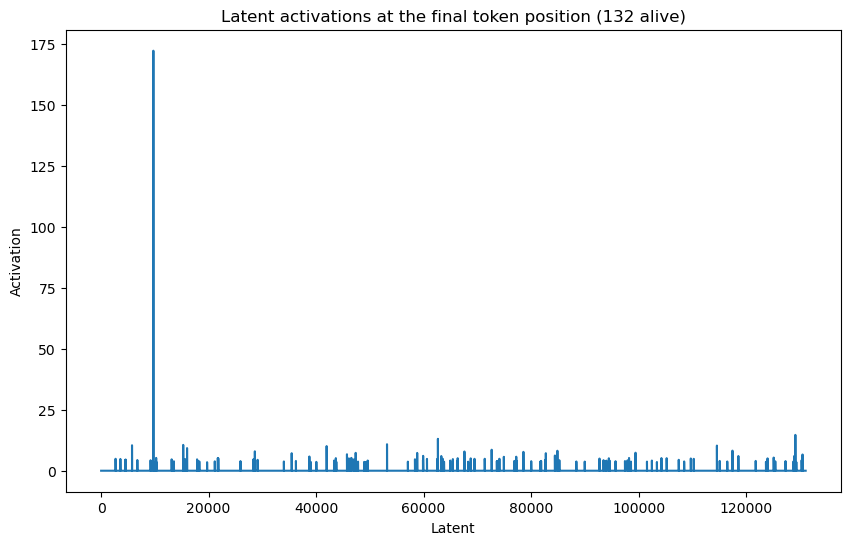

Latent 9718 had activation 172.12
Latent 129153 had activation 14.69
Latent 62653 had activation 13.07
Latent 53185 had activation 10.85
Latent 15271 had activation 10.58
Latent 5747 had activation 10.43
Latent 114557 had activation 10.30
Latent 41951 had activation 10.10
Latent 15986 had activation 9.27
Latent 72652 had activation 8.61
Latent 117451 had activation 8.23
Latent 84883 had activation 8.19
Latent 28597 had activation 7.95
Latent 67587 had activation 7.88
Latent 78561 had activation 7.74
Latent 99416 had activation 7.38
Latent 47353 had activation 7.33
Latent 58799 had activation 7.29
Latent 82729 had activation 7.18
Latent 35449 had activation 7.18
Latent 45734 had activation 6.74
Latent 130487 had activation 6.65
Latent 84417 had activation 6.23
Latent 59907 had activation 6.09
Latent 118549 had activation 6.03
Latent 63281 had activation 6.02
Latent 128932 had activation 6.01
Latent 38741 had activation 5.83
Latent 77228 had activation 5.74
Latent 74918 had activation 5.

In [28]:
import matplotlib.pyplot as plt
from tools.sae import display_dashboard


#vec_slice = model.blocks[22].ln2(original_vec)


sae_acts_post = sae.encode(original_vec.squeeze(0))
#sae_acts_post = sae.encode(vec_slice.squeeze(0))

# Plot the latent activations
plt.figure(figsize=(10, 6))
plt.plot(sae_acts_post.cpu().numpy())
plt.title(f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)")
plt.xlabel("Latent")
plt.ylabel("Activation")
plt.show()

# Print the top 3 latents, and inspect their dashboards
top_activations, top_indices = sae_acts_post.topk(50, largest=True)

for act, ind in zip(top_activations, top_indices):
    print(f"Latent {ind.item()} had activation {act.item():.2f}")
    #display_dashboard(latent_idx=ind.item(), sae_release=sae_release, sae_id=sae_id)

In [5]:

sae_acts_post = sae.encode(original_vec.squeeze(0))

## Load Dataset

In [6]:
data_df = pd.read_csv("data/final_data_filtered.csv")
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

df = data_df.query("country=='Turkey' and hint=='none' and ans_type=='west'").copy()

df["text"] = data_df.apply(lambda x: f"{x['input']}{prompt_suffix[x['lang']]}", axis=1)
df["label"] = data_df["ans_local"].apply(lambda x: x+"**")

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyTextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["text"]
        label = row["label"]  # integer class
        # tokenize
        tokenized = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length",
            add_special_tokens=False,
            return_tensors="pt"
        )
        # for classification, we might not need to shift labels as in next-token LM
        return {
            "input_ids": tokenized["input_ids"].squeeze(0),
            "attention_mask": tokenized["attention_mask"].squeeze(0),
            "label": tokenizer(label, add_special_tokens=False)
        }

dataset = MyTextDataset(df.sample(400), tokenizer)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## Model

In [32]:
from collections import OrderedDict
from typing import Dict, Callable
import torch

def remove_all_forward_hooks(model: torch.nn.Module) -> None:
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks: Dict[int, Callable] = OrderedDict()
            remove_all_forward_hooks(child)

remove_all_forward_hooks(model)

In [8]:
def injection_hook(module, input, output):
    # output shape is [batch_size, seq_len, hidden_dim]
    # decode z
    #z = model.blocks[22].ln2(z)
    decoded = z @ sae.W_dec
    #decoded = sae.decode(z)                     # [hidden_dim]
    decoded = decoded.unsqueeze(0).unsqueeze(1) # [1,1,hidden_dim]
    
    decoded = decoded.expand(output.size(0), 1, -1)
    mask = t.zeros_like(output)
    mask[:,-1,:] = 1

    return output + 4 * decoded * mask  # broadcast add


z = t.nn.Parameter(sae_acts_post, requires_grad=True).to(device)

In [9]:
model.blocks[22].hook_resid_post.register_forward_hook(injection_hook)

In [10]:
for param in model.parameters():
    param.requires_grad = False

In [11]:
cross_entropy = t.nn.CrossEntropyLoss()

def lm_loss_function(logits, targets):
    # logits: [batch_size, seq_len, vocab_size]
    # targets: [batch_size, seq_len]
    # Typically we shift targets by 1 for next-token prediction, etc.
    return cross_entropy(logits, targets)

def l1_penalty_z(z):
    # z is [latent_dim]
    # sum |z_i| over i where mask[i] == True
    return (z.abs()).sum()


def alignment_penalty(decoded, ref):
    return t.nn.functional.mse_loss(decoded, ref)


lambda_ce = 1.0
lambda_l0 = 10
lambda_align = 10

def combined_loss_fn(logits, targets, z, reference_vector):
    loss_ce = lm_loss_function(logits, targets)
    loss_l0 = l1_penalty_z(z)  # or a better approach
    decoded = sae.decode(z)
    loss_align = alignment_penalty(decoded, reference_vector)
    
    # add steering vector coefficient as param

    return (lambda_ce * loss_ce
            + lambda_l0 * loss_l0
            + lambda_align * loss_align)

In [12]:
latent_dim = sae_acts_post.size(0)

# Example mask: 1 = trainable, 0 = frozen
trainable_mask = sae_acts_post > 0

def zero_grad_frozen_dims(param, mask):
    """
    In-place zero out gradient for positions we want to freeze.
    This ensures those positions don't update even if they have gradients.
    """
    if param.grad is not None:
        param.grad[~mask] = 0.0


In [29]:
sae.W_dec.shape

torch.Size([131072, 3584])

In [37]:
decoded

tensor([ 0.6055, -1.2307,  0.0938,  ...,  0.3399, -0.9775,  0.1559],
       device='cuda:0')

In [14]:
from tqdm import tqdm

reference_vector = original_vec.to(device)  # shape [hidden_dim]

optimizer = torch.optim.Adam(
    [z], 
    lr=1e-3
)

num_epochs = 3

lambda_ce = 1.0
lambda_l0 = 10
lambda_align = 10

for epoch in range(num_epochs):
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"]["input_ids"][-1].to(device)

        optimizer.zero_grad()

        # Forward pass => injection_hook => hidden + decoder(z)
        # We'll assume the model outputs classification logits
        
        outputs = model.forward(input_ids, attention_mask=attention_mask)
        # For some HuggingFace models, logits might be in outputs.logits
        logits = outputs  # [batch_size, num_classes]

        # Compute combined loss
        #loss = combined_loss_fn(logits[:,-1,:], label, z, reference_vector)

        loss_ce = cross_entropy(logits[:,-1,:], label)
        loss_l0 = z.abs().sum()
        decoded = z @ sae.W_dec
        loss_align = ((decoded - reference_vector)**2).mean()

        loss =  (lambda_ce * loss_ce + lambda_l0 * loss_l0 + lambda_align * loss_align)
        loss.requires_grad = True
        loss.backward()
        print(z.grad)

        # Zero grad in the frozen dims of z
        zero_grad_frozen_dims(z, trainable_mask)

        optimizer.step()
        


    print(f"Epoch {epoch} finished. Last batch loss = {loss.item():.4f}")


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 2/400 [00:00<00:55,  7.16it/s]

None
None


  1%|          | 4/400 [00:00<00:57,  6.83it/s]

None
None


  2%|▏         | 6/400 [00:00<00:58,  6.72it/s]

None
None


  2%|▏         | 8/400 [00:01<00:54,  7.13it/s]

None
None


  2%|▎         | 10/400 [00:01<00:52,  7.40it/s]

None
None


  3%|▎         | 12/400 [00:01<00:52,  7.44it/s]

None
None


  4%|▎         | 14/400 [00:01<00:51,  7.47it/s]

None
None


  4%|▍         | 16/400 [00:02<00:55,  6.88it/s]

None
None


  4%|▍         | 18/400 [00:02<00:56,  6.72it/s]

None
None


  5%|▌         | 20/400 [00:02<00:54,  6.93it/s]

None
None


  6%|▌         | 22/400 [00:03<00:51,  7.35it/s]

None
None


  6%|▌         | 24/400 [00:03<00:50,  7.38it/s]

None
None


  6%|▋         | 26/400 [00:03<00:49,  7.53it/s]

None
None


  7%|▋         | 28/400 [00:03<00:49,  7.54it/s]

None
None


  8%|▊         | 30/400 [00:04<00:48,  7.62it/s]

None
None


  8%|▊         | 32/400 [00:04<00:50,  7.30it/s]

None
None


  8%|▊         | 34/400 [00:04<00:51,  7.16it/s]

None
None


  9%|▉         | 36/400 [00:05<00:51,  7.08it/s]

None
None


 10%|▉         | 38/400 [00:05<00:49,  7.24it/s]

None
None


 10%|█         | 40/400 [00:05<00:47,  7.62it/s]

None
None


 10%|█         | 42/400 [00:05<00:47,  7.59it/s]

None
None


 11%|█         | 44/400 [00:06<00:48,  7.29it/s]

None
None


 12%|█▏        | 46/400 [00:06<00:51,  6.93it/s]

None
None


 12%|█▏        | 48/400 [00:06<00:49,  7.12it/s]

None
None


 12%|█▎        | 50/400 [00:06<00:46,  7.45it/s]

None
None


 13%|█▎        | 52/400 [00:07<00:44,  7.74it/s]

None
None


 14%|█▎        | 54/400 [00:07<00:44,  7.82it/s]

None
None


 14%|█▍        | 56/400 [00:07<00:44,  7.70it/s]

None
None


 14%|█▍        | 58/400 [00:07<00:47,  7.21it/s]

None
None


 15%|█▌        | 60/400 [00:08<00:48,  6.95it/s]

None
None


 16%|█▌        | 62/400 [00:08<00:50,  6.73it/s]

None
None


 16%|█▌        | 64/400 [00:08<00:47,  7.06it/s]

None
None


 16%|█▋        | 66/400 [00:09<00:44,  7.48it/s]

None
None


 17%|█▋        | 68/400 [00:09<00:43,  7.64it/s]

None
None


 18%|█▊        | 70/400 [00:09<00:42,  7.76it/s]

None
None


 18%|█▊        | 72/400 [00:09<00:43,  7.55it/s]

None
None


 18%|█▊        | 74/400 [00:10<00:43,  7.49it/s]

None
None


 19%|█▉        | 76/400 [00:10<00:47,  6.80it/s]

None
None


 20%|█▉        | 78/400 [00:10<00:45,  7.00it/s]

None
None


 20%|██        | 80/400 [00:11<00:45,  7.00it/s]

None
None


 20%|██        | 82/400 [00:11<00:43,  7.35it/s]

None
None


 21%|██        | 84/400 [00:11<00:42,  7.48it/s]

None
None


 22%|██▏       | 86/400 [00:11<00:41,  7.61it/s]

None
None


 22%|██▏       | 88/400 [00:12<00:41,  7.51it/s]

None
None


 22%|██▎       | 90/400 [00:12<00:41,  7.51it/s]

None
None


 23%|██▎       | 92/400 [00:12<00:42,  7.25it/s]

None
None


 24%|██▎       | 94/400 [00:12<00:40,  7.47it/s]

None
None


 24%|██▍       | 96/400 [00:13<00:39,  7.68it/s]

None
None


 24%|██▍       | 98/400 [00:13<00:38,  7.85it/s]

None
None


 25%|██▌       | 100/400 [00:13<00:38,  7.77it/s]

None
None


 26%|██▌       | 102/400 [00:13<00:38,  7.69it/s]

None
None


 26%|██▌       | 104/400 [00:14<00:39,  7.40it/s]

None
None


 26%|██▋       | 106/400 [00:14<00:42,  6.90it/s]

None
None


 27%|██▋       | 108/400 [00:14<00:40,  7.13it/s]

None
None


 28%|██▊       | 110/400 [00:15<00:39,  7.27it/s]

None
None


 28%|██▊       | 112/400 [00:15<00:39,  7.35it/s]

None
None


 28%|██▊       | 114/400 [00:15<00:38,  7.51it/s]

None
None


 29%|██▉       | 116/400 [00:15<00:38,  7.32it/s]

None
None


 30%|██▉       | 118/400 [00:16<00:39,  7.16it/s]

None
None


 30%|███       | 120/400 [00:16<00:39,  7.08it/s]

None
None


 30%|███       | 122/400 [00:16<00:38,  7.21it/s]

None
None


 31%|███       | 124/400 [00:16<00:37,  7.38it/s]

None
None


 32%|███▏      | 126/400 [00:17<00:35,  7.67it/s]

None
None


 32%|███▏      | 128/400 [00:17<00:34,  7.81it/s]

None
None


 32%|███▎      | 130/400 [00:17<00:36,  7.39it/s]

None
None


 33%|███▎      | 132/400 [00:18<00:37,  7.18it/s]

None
None


 34%|███▎      | 134/400 [00:18<00:37,  7.14it/s]

None
None


 34%|███▍      | 136/400 [00:18<00:35,  7.33it/s]

None
None


 34%|███▍      | 138/400 [00:18<00:35,  7.30it/s]

None
None


 35%|███▌      | 140/400 [00:19<00:34,  7.55it/s]

None
None


 36%|███▌      | 142/400 [00:19<00:34,  7.59it/s]

None
None


 36%|███▌      | 144/400 [00:19<00:33,  7.72it/s]

None
None


 36%|███▋      | 146/400 [00:19<00:34,  7.29it/s]

None
None


 37%|███▋      | 148/400 [00:20<00:33,  7.60it/s]

None
None


 38%|███▊      | 150/400 [00:20<00:33,  7.41it/s]

None
None


 38%|███▊      | 152/400 [00:20<00:33,  7.46it/s]

None
None


 38%|███▊      | 154/400 [00:20<00:31,  7.69it/s]

None
None


 39%|███▉      | 156/400 [00:21<00:31,  7.74it/s]

None
None


 40%|███▉      | 158/400 [00:21<00:30,  8.01it/s]

None
None


 40%|████      | 160/400 [00:21<00:34,  6.93it/s]

None
None


 40%|████      | 162/400 [00:22<00:32,  7.26it/s]

None
None


 41%|████      | 164/400 [00:22<00:31,  7.51it/s]

None
None


 42%|████▏     | 166/400 [00:22<00:31,  7.34it/s]

None
None


 42%|████▏     | 168/400 [00:22<00:30,  7.56it/s]

None
None


 42%|████▎     | 170/400 [00:23<00:30,  7.45it/s]

None
None


 43%|████▎     | 172/400 [00:23<00:29,  7.66it/s]

None
None


 44%|████▎     | 174/400 [00:23<00:30,  7.35it/s]

None
None


 44%|████▍     | 176/400 [00:23<00:29,  7.57it/s]

None
None


 44%|████▍     | 178/400 [00:24<00:28,  7.67it/s]

None
None


 45%|████▌     | 180/400 [00:24<00:28,  7.62it/s]

None
None


 46%|████▌     | 182/400 [00:24<00:28,  7.71it/s]

None
None


 46%|████▌     | 184/400 [00:24<00:27,  7.87it/s]

None
None


 46%|████▋     | 186/400 [00:25<00:26,  7.98it/s]

None
None


 47%|████▋     | 188/400 [00:25<00:26,  8.09it/s]

None
None


 48%|████▊     | 190/400 [00:25<00:27,  7.68it/s]

None
None


 48%|████▊     | 192/400 [00:25<00:26,  7.72it/s]

None
None


 48%|████▊     | 194/400 [00:26<00:26,  7.78it/s]

None
None


 49%|████▉     | 196/400 [00:26<00:28,  7.27it/s]

None
None


 50%|████▉     | 198/400 [00:26<00:25,  7.84it/s]

None
None


 50%|█████     | 200/400 [00:27<00:25,  7.94it/s]

None
None


 50%|█████     | 202/400 [00:27<00:23,  8.29it/s]

None
None


 51%|█████     | 204/400 [00:27<00:23,  8.19it/s]

None
None


 52%|█████▏    | 206/400 [00:27<00:23,  8.31it/s]

None
None


 52%|█████▏    | 208/400 [00:27<00:22,  8.50it/s]

None
None


 52%|█████▎    | 210/400 [00:28<00:21,  8.66it/s]

None
None


 53%|█████▎    | 212/400 [00:28<00:21,  8.64it/s]

None
None


 54%|█████▎    | 214/400 [00:28<00:22,  8.44it/s]

None
None


 54%|█████▍    | 216/400 [00:28<00:21,  8.56it/s]

None
None


 55%|█████▍    | 218/400 [00:29<00:21,  8.66it/s]

None
None


 55%|█████▌    | 220/400 [00:29<00:22,  8.14it/s]

None
None


 56%|█████▌    | 222/400 [00:29<00:21,  8.18it/s]

None
None


 56%|█████▌    | 224/400 [00:29<00:20,  8.58it/s]

None
None


 56%|█████▋    | 226/400 [00:30<00:19,  8.80it/s]

None
None


 57%|█████▋    | 228/400 [00:30<00:19,  8.75it/s]

None
None


 57%|█████▊    | 230/400 [00:30<00:21,  8.01it/s]

None
None


 58%|█████▊    | 232/400 [00:30<00:20,  8.18it/s]

None
None


 58%|█████▊    | 234/400 [00:31<00:21,  7.56it/s]

None
None


 59%|█████▉    | 236/400 [00:31<00:21,  7.67it/s]

None
None


 60%|█████▉    | 238/400 [00:31<00:20,  8.02it/s]

None
None


 60%|██████    | 240/400 [00:31<00:19,  8.39it/s]

None
None


 60%|██████    | 242/400 [00:32<00:18,  8.61it/s]

None
None


 61%|██████    | 244/400 [00:32<00:17,  8.69it/s]

None
None


 62%|██████▏   | 246/400 [00:32<00:17,  8.65it/s]

None
None


 62%|██████▏   | 248/400 [00:32<00:17,  8.63it/s]

None
None


 62%|██████▎   | 250/400 [00:32<00:18,  8.12it/s]

None
None


 63%|██████▎   | 252/400 [00:33<00:17,  8.39it/s]

None
None


 64%|██████▎   | 254/400 [00:33<00:18,  8.09it/s]

None
None


 64%|██████▍   | 256/400 [00:33<00:17,  8.09it/s]

None
None


 64%|██████▍   | 258/400 [00:33<00:17,  8.24it/s]

None
None


 65%|██████▌   | 260/400 [00:34<00:17,  8.15it/s]

None
None


 66%|██████▌   | 262/400 [00:34<00:16,  8.51it/s]

None
None


 66%|██████▌   | 264/400 [00:34<00:16,  8.08it/s]

None
None


 66%|██████▋   | 266/400 [00:34<00:17,  7.55it/s]

None
None


 67%|██████▋   | 268/400 [00:35<00:17,  7.61it/s]

None
None


 68%|██████▊   | 270/400 [00:35<00:16,  8.07it/s]

None
None


 68%|██████▊   | 272/400 [00:35<00:14,  8.56it/s]

None
None


 68%|██████▊   | 274/400 [00:35<00:14,  8.86it/s]

None
None


 69%|██████▉   | 276/400 [00:36<00:14,  8.44it/s]

None
None


 70%|██████▉   | 278/400 [00:36<00:14,  8.60it/s]

None
None


 70%|███████   | 280/400 [00:36<00:13,  8.76it/s]

None
None


 70%|███████   | 282/400 [00:36<00:13,  8.48it/s]

None
None


 71%|███████   | 284/400 [00:37<00:13,  8.55it/s]

None
None


 72%|███████▏  | 286/400 [00:37<00:15,  7.57it/s]

None
None


 72%|███████▏  | 288/400 [00:37<00:14,  7.91it/s]

None
None


 72%|███████▎  | 290/400 [00:37<00:13,  8.30it/s]

None
None


 73%|███████▎  | 292/400 [00:38<00:12,  8.50it/s]

None
None


 74%|███████▎  | 294/400 [00:38<00:13,  8.03it/s]

None
None


 74%|███████▍  | 296/400 [00:38<00:13,  7.92it/s]

None
None


 74%|███████▍  | 298/400 [00:38<00:13,  7.42it/s]

None
None


 75%|███████▌  | 300/400 [00:39<00:13,  7.55it/s]

None
None


 76%|███████▌  | 302/400 [00:39<00:12,  8.15it/s]

None
None


 76%|███████▌  | 304/400 [00:39<00:11,  8.56it/s]

None
None


 76%|███████▋  | 306/400 [00:39<00:10,  8.79it/s]

None
None


 77%|███████▋  | 308/400 [00:40<00:10,  8.87it/s]

None
None


 78%|███████▊  | 310/400 [00:40<00:10,  8.24it/s]

None
None


 78%|███████▊  | 312/400 [00:40<00:11,  7.88it/s]

None
None


 78%|███████▊  | 314/400 [00:40<00:10,  8.40it/s]

None
None


 79%|███████▉  | 316/400 [00:41<00:10,  8.35it/s]

None
None


 80%|███████▉  | 318/400 [00:41<00:09,  8.51it/s]

None
None


 80%|████████  | 320/400 [00:41<00:09,  8.35it/s]

None
None


 80%|████████  | 322/400 [00:41<00:09,  8.41it/s]

None
None


 81%|████████  | 324/400 [00:41<00:08,  8.61it/s]

None
None


 82%|████████▏ | 326/400 [00:42<00:08,  8.78it/s]

None
None


 82%|████████▏ | 328/400 [00:42<00:08,  8.72it/s]

None
None


 82%|████████▎ | 330/400 [00:42<00:08,  8.40it/s]

None
None


 83%|████████▎ | 332/400 [00:42<00:08,  8.24it/s]

None
None


 84%|████████▎ | 334/400 [00:43<00:07,  8.32it/s]

None
None


 84%|████████▍ | 336/400 [00:43<00:07,  8.64it/s]

None
None


 84%|████████▍ | 338/400 [00:43<00:06,  8.86it/s]

None
None


 85%|████████▌ | 340/400 [00:43<00:06,  9.00it/s]

None
None


 86%|████████▌ | 342/400 [00:44<00:06,  9.05it/s]

None
None


 86%|████████▌ | 344/400 [00:44<00:06,  8.39it/s]

None
None


 86%|████████▋ | 346/400 [00:44<00:06,  8.07it/s]

None
None


 87%|████████▋ | 348/400 [00:44<00:06,  8.61it/s]

None
None


 88%|████████▊ | 350/400 [00:44<00:05,  8.88it/s]

None
None


 88%|████████▊ | 352/400 [00:45<00:05,  9.02it/s]

None
None


 88%|████████▊ | 354/400 [00:45<00:05,  8.96it/s]

None
None


 89%|████████▉ | 356/400 [00:45<00:05,  8.11it/s]

None
None


 90%|████████▉ | 358/400 [00:45<00:05,  8.00it/s]

None
None


 90%|█████████ | 360/400 [00:46<00:04,  8.27it/s]

None
None


 90%|█████████ | 362/400 [00:46<00:04,  8.53it/s]

None
None


 91%|█████████ | 364/400 [00:46<00:04,  8.70it/s]

None
None


 92%|█████████▏| 366/400 [00:46<00:03,  8.80it/s]

None
None


 92%|█████████▏| 368/400 [00:47<00:03,  8.02it/s]

None
None


 92%|█████████▎| 370/400 [00:47<00:03,  8.33it/s]

None
None


 93%|█████████▎| 372/400 [00:47<00:03,  8.66it/s]

None
None


 94%|█████████▎| 374/400 [00:47<00:03,  8.17it/s]

None
None


 94%|█████████▍| 376/400 [00:48<00:02,  8.30it/s]

None
None


 94%|█████████▍| 378/400 [00:48<00:02,  8.17it/s]

None
None


 95%|█████████▌| 380/400 [00:48<00:02,  8.26it/s]

None
None


 96%|█████████▌| 382/400 [00:48<00:02,  8.64it/s]

None
None


 96%|█████████▌| 384/400 [00:49<00:01,  8.86it/s]

None
None


 96%|█████████▋| 386/400 [00:49<00:01,  9.00it/s]

None
None


 97%|█████████▋| 388/400 [00:49<00:01,  8.68it/s]

None
None


 98%|█████████▊| 390/400 [00:49<00:01,  7.75it/s]

None
None


 98%|█████████▊| 392/400 [00:50<00:00,  8.23it/s]

None
None


 98%|█████████▊| 394/400 [00:50<00:00,  8.50it/s]

None
None


 99%|█████████▉| 396/400 [00:50<00:00,  8.74it/s]

None
None


100%|█████████▉| 398/400 [00:50<00:00,  8.94it/s]

None
None


100%|██████████| 400/400 [00:50<00:00,  7.86it/s]


None
None
Epoch 0 finished. Last batch loss = 8578.7891


  0%|          | 2/400 [00:00<00:46,  8.55it/s]

None
None


  1%|          | 4/400 [00:00<00:48,  8.15it/s]

None
None


  2%|▏         | 6/400 [00:00<00:49,  7.98it/s]

None
None


  2%|▏         | 8/400 [00:00<00:47,  8.26it/s]

None
None


  2%|▎         | 10/400 [00:01<00:45,  8.62it/s]

None
None


  3%|▎         | 12/400 [00:01<00:44,  8.64it/s]

None
None


  4%|▎         | 14/400 [00:01<00:45,  8.51it/s]

None
None


  4%|▍         | 16/400 [00:01<00:46,  8.29it/s]

None
None


  4%|▍         | 18/400 [00:02<00:44,  8.64it/s]

None
None


  5%|▌         | 20/400 [00:02<00:43,  8.75it/s]

None
None


  6%|▌         | 22/400 [00:02<00:43,  8.72it/s]

None
None


  6%|▌         | 24/400 [00:02<00:42,  8.76it/s]

None
None


  6%|▋         | 26/400 [00:03<00:45,  8.24it/s]

None
None


  7%|▋         | 28/400 [00:03<00:44,  8.35it/s]

None
None


  8%|▊         | 30/400 [00:03<00:47,  7.83it/s]

None
None


  8%|▊         | 32/400 [00:03<00:46,  7.88it/s]

None
None


  8%|▊         | 34/400 [00:04<00:48,  7.57it/s]

None
None


  9%|▉         | 36/400 [00:04<00:50,  7.25it/s]

None
None


 10%|▉         | 38/400 [00:04<00:52,  6.90it/s]

None
None


 10%|█         | 40/400 [00:04<00:47,  7.50it/s]

None
None


 10%|█         | 42/400 [00:05<00:45,  7.81it/s]

None
None


 11%|█         | 44/400 [00:05<00:47,  7.54it/s]

None
None


 12%|█▏        | 46/400 [00:05<00:48,  7.29it/s]

None
None


 12%|█▏        | 48/400 [00:06<00:50,  6.96it/s]

None
None


 12%|█▎        | 50/400 [00:06<00:52,  6.68it/s]

None
None


 13%|█▎        | 52/400 [00:06<00:55,  6.28it/s]

None
None


 14%|█▎        | 54/400 [00:07<00:53,  6.43it/s]

None
None


 14%|█▍        | 56/400 [00:07<00:55,  6.15it/s]

None
None


 14%|█▍        | 58/400 [00:07<00:51,  6.68it/s]

None
None


 15%|█▌        | 60/400 [00:07<00:52,  6.52it/s]

None
None


 16%|█▌        | 62/400 [00:08<00:47,  7.08it/s]

None
None


 16%|█▌        | 64/400 [00:08<00:44,  7.56it/s]

None
None


 16%|█▋        | 66/400 [00:08<00:45,  7.27it/s]

None
None


 17%|█▋        | 68/400 [00:08<00:42,  7.77it/s]

None
None


 18%|█▊        | 70/400 [00:09<00:40,  8.05it/s]

None
None


 18%|█▊        | 72/400 [00:09<00:39,  8.20it/s]

None
None


 18%|█▊        | 74/400 [00:09<00:39,  8.24it/s]

None
None


 19%|█▉        | 76/400 [00:09<00:42,  7.54it/s]

None
None


 20%|█▉        | 78/400 [00:10<00:41,  7.79it/s]

None
None


 20%|██        | 80/400 [00:10<00:39,  8.08it/s]

None
None


 20%|██        | 82/400 [00:10<00:38,  8.22it/s]

None
None


 21%|██        | 84/400 [00:10<00:38,  8.23it/s]

None
None


 22%|██▏       | 86/400 [00:11<00:38,  8.26it/s]

None
None


 22%|██▏       | 88/400 [00:11<00:37,  8.30it/s]

None
None


 22%|██▎       | 90/400 [00:11<00:37,  8.30it/s]

None
None


 23%|██▎       | 92/400 [00:11<00:41,  7.36it/s]

None
None


 24%|██▎       | 94/400 [00:12<00:40,  7.52it/s]

None
None


 24%|██▍       | 96/400 [00:12<00:38,  7.95it/s]

None
None


 24%|██▍       | 98/400 [00:12<00:40,  7.54it/s]

None
None


 25%|██▌       | 100/400 [00:13<00:38,  7.89it/s]

None
None


 26%|██▌       | 102/400 [00:13<00:36,  8.12it/s]

None
None


 26%|██▌       | 104/400 [00:13<00:36,  8.21it/s]

None
None


 26%|██▋       | 106/400 [00:13<00:37,  7.82it/s]

None
None


 27%|██▋       | 108/400 [00:14<00:37,  7.77it/s]

None
None


 28%|██▊       | 110/400 [00:14<00:36,  7.94it/s]

None
None


 28%|██▊       | 112/400 [00:14<00:35,  8.15it/s]

None
None


 28%|██▊       | 114/400 [00:14<00:35,  8.14it/s]

None
None


 29%|██▉       | 116/400 [00:14<00:34,  8.14it/s]

None
None


 30%|██▉       | 118/400 [00:15<00:34,  8.25it/s]

None
None


 30%|███       | 120/400 [00:15<00:33,  8.35it/s]

None
None


 30%|███       | 122/400 [00:15<00:36,  7.62it/s]

None
None


 31%|███       | 124/400 [00:15<00:34,  7.91it/s]

None
None


 32%|███▏      | 126/400 [00:16<00:34,  7.94it/s]

None
None


 32%|███▏      | 128/400 [00:16<00:33,  8.12it/s]

None
None


 32%|███▎      | 130/400 [00:16<00:33,  8.15it/s]

None
None


 33%|███▎      | 132/400 [00:16<00:34,  7.82it/s]

None
None


 34%|███▎      | 134/400 [00:17<00:34,  7.78it/s]

None
None


 34%|███▍      | 136/400 [00:17<00:35,  7.53it/s]

None
None


 34%|███▍      | 138/400 [00:17<00:35,  7.34it/s]

None
None


 35%|███▌      | 140/400 [00:18<00:36,  7.04it/s]

None
None


 36%|███▌      | 142/400 [00:18<00:35,  7.30it/s]

None
None


 36%|███▌      | 144/400 [00:18<00:34,  7.50it/s]

None
None


 36%|███▋      | 146/400 [00:18<00:33,  7.70it/s]

None
None


 37%|███▋      | 148/400 [00:19<00:34,  7.30it/s]

None
None


 38%|███▊      | 150/400 [00:19<00:34,  7.27it/s]

None
None


 38%|███▊      | 152/400 [00:19<00:37,  6.64it/s]

None
None


 38%|███▊      | 154/400 [00:20<00:38,  6.34it/s]

None
None


 39%|███▉      | 156/400 [00:20<00:36,  6.77it/s]

None
None


 40%|███▉      | 158/400 [00:20<00:33,  7.23it/s]

None
None


 40%|████      | 160/400 [00:20<00:32,  7.48it/s]

None
None


 40%|████      | 162/400 [00:21<00:33,  7.05it/s]

None
None


 41%|████      | 164/400 [00:21<00:35,  6.62it/s]

None
None


 42%|████▏     | 166/400 [00:21<00:32,  7.23it/s]

None
None


 42%|████▏     | 168/400 [00:22<00:29,  7.75it/s]

None
None


 42%|████▎     | 170/400 [00:22<00:28,  8.18it/s]

None
None


 43%|████▎     | 172/400 [00:22<00:27,  8.34it/s]

None
None


 44%|████▎     | 174/400 [00:22<00:26,  8.37it/s]

None
None


 44%|████▍     | 176/400 [00:22<00:27,  8.27it/s]

None
None


 44%|████▍     | 178/400 [00:23<00:26,  8.39it/s]

None
None


 45%|████▌     | 180/400 [00:23<00:27,  7.94it/s]

None
None


 46%|████▌     | 182/400 [00:23<00:26,  8.25it/s]

None
None


 46%|████▌     | 184/400 [00:23<00:25,  8.51it/s]

None
None


 46%|████▋     | 186/400 [00:24<00:24,  8.67it/s]

None
None


 47%|████▋     | 188/400 [00:24<00:24,  8.66it/s]

None
None


 48%|████▊     | 190/400 [00:24<00:24,  8.69it/s]

None
None


 48%|████▊     | 192/400 [00:24<00:23,  8.74it/s]

None
None


 48%|████▊     | 194/400 [00:25<00:23,  8.74it/s]

None
None


 49%|████▉     | 196/400 [00:25<00:26,  7.62it/s]

None
None


 50%|████▉     | 198/400 [00:25<00:25,  8.03it/s]

None
None


 50%|█████     | 200/400 [00:25<00:24,  8.04it/s]

None
None


 50%|█████     | 202/400 [00:26<00:23,  8.42it/s]

None
None


 51%|█████     | 204/400 [00:26<00:22,  8.79it/s]

None
None


 52%|█████▏    | 206/400 [00:26<00:22,  8.61it/s]

None
None


 52%|█████▏    | 208/400 [00:26<00:23,  8.24it/s]

None
None


 52%|█████▎    | 210/400 [00:27<00:22,  8.63it/s]

None
None


 53%|█████▎    | 212/400 [00:27<00:22,  8.48it/s]

None
None


 54%|█████▎    | 214/400 [00:27<00:21,  8.58it/s]

None
None


 54%|█████▍    | 216/400 [00:27<00:21,  8.58it/s]

None
None


 55%|█████▍    | 218/400 [00:27<00:23,  7.68it/s]

None
None


 55%|█████▌    | 220/400 [00:28<00:22,  8.10it/s]

None
None


 56%|█████▌    | 222/400 [00:28<00:20,  8.52it/s]

None
None


 56%|█████▌    | 224/400 [00:28<00:20,  8.64it/s]

None
None


 56%|█████▋    | 226/400 [00:28<00:21,  8.02it/s]

None
None


 57%|█████▋    | 228/400 [00:29<00:21,  7.86it/s]

None
None


 57%|█████▊    | 230/400 [00:29<00:23,  7.22it/s]

None
None


 58%|█████▊    | 232/400 [00:29<00:22,  7.62it/s]

None
None


 58%|█████▊    | 234/400 [00:29<00:20,  8.10it/s]

None
None


 59%|█████▉    | 236/400 [00:30<00:19,  8.48it/s]

None
None


 60%|█████▉    | 238/400 [00:30<00:18,  8.72it/s]

None
None


 60%|██████    | 240/400 [00:30<00:19,  8.19it/s]

None
None


 60%|██████    | 242/400 [00:30<00:21,  7.33it/s]

None
None


 61%|██████    | 244/400 [00:31<00:23,  6.68it/s]

None
None


 62%|██████▏   | 246/400 [00:31<00:21,  7.21it/s]

None
None


 62%|██████▏   | 248/400 [00:31<00:20,  7.49it/s]

None
None


 62%|██████▎   | 250/400 [00:32<00:19,  7.82it/s]

None
None


 63%|██████▎   | 252/400 [00:32<00:18,  8.01it/s]

None
None


 64%|██████▎   | 254/400 [00:32<00:17,  8.13it/s]

None
None


 64%|██████▍   | 256/400 [00:32<00:19,  7.34it/s]

None
None


 64%|██████▍   | 258/400 [00:33<00:21,  6.50it/s]

None
None


 65%|██████▌   | 260/400 [00:33<00:20,  6.68it/s]

None
None


 66%|██████▌   | 262/400 [00:33<00:19,  7.08it/s]

None
None


 66%|██████▌   | 264/400 [00:33<00:18,  7.36it/s]

None
None


 66%|██████▋   | 266/400 [00:34<00:17,  7.66it/s]

None
None


 67%|██████▋   | 268/400 [00:34<00:16,  7.86it/s]

None
None


 68%|██████▊   | 270/400 [00:34<00:18,  7.14it/s]

None
None


 68%|██████▊   | 272/400 [00:35<00:18,  6.94it/s]

None
None


 68%|██████▊   | 274/400 [00:35<00:16,  7.56it/s]

None
None


 69%|██████▉   | 276/400 [00:35<00:16,  7.62it/s]

None
None


 70%|██████▉   | 278/400 [00:35<00:15,  7.89it/s]

None
None


 70%|███████   | 280/400 [00:36<00:16,  7.06it/s]

None
None


 70%|███████   | 282/400 [00:36<00:15,  7.40it/s]

None
None


 71%|███████   | 284/400 [00:36<00:15,  7.31it/s]

None
None


 72%|███████▏  | 286/400 [00:36<00:14,  7.69it/s]

None
None


 72%|███████▏  | 288/400 [00:37<00:14,  7.58it/s]

None
None


 72%|███████▎  | 290/400 [00:37<00:14,  7.58it/s]

None
None


 73%|███████▎  | 292/400 [00:37<00:14,  7.25it/s]

None
None


 74%|███████▎  | 294/400 [00:38<00:15,  6.98it/s]

None
None


 74%|███████▍  | 296/400 [00:38<00:14,  7.37it/s]

None
None


 74%|███████▍  | 298/400 [00:38<00:14,  6.98it/s]

None
None


 75%|███████▌  | 300/400 [00:38<00:14,  7.04it/s]

None
None


 76%|███████▌  | 302/400 [00:39<00:13,  7.53it/s]

None
None


 76%|███████▌  | 304/400 [00:39<00:12,  7.91it/s]

None
None


 76%|███████▋  | 306/400 [00:39<00:11,  8.11it/s]

None
None


 77%|███████▋  | 308/400 [00:39<00:11,  7.84it/s]

None
None


 78%|███████▊  | 310/400 [00:40<00:11,  7.55it/s]

None
None


 78%|███████▊  | 312/400 [00:40<00:12,  7.10it/s]

None
None


 78%|███████▊  | 314/400 [00:40<00:11,  7.39it/s]

None
None


 79%|███████▉  | 316/400 [00:40<00:10,  7.67it/s]

None
None


 80%|███████▉  | 318/400 [00:41<00:10,  8.06it/s]

None
None


 80%|████████  | 320/400 [00:41<00:10,  7.80it/s]

None
None


 80%|████████  | 322/400 [00:41<00:10,  7.66it/s]

None
None


 81%|████████  | 324/400 [00:42<00:10,  7.20it/s]

None
None


 82%|████████▏ | 326/400 [00:42<00:10,  6.76it/s]

None
None


 82%|████████▏ | 328/400 [00:42<00:10,  7.07it/s]

None
None


 82%|████████▎ | 330/400 [00:42<00:09,  7.34it/s]

None
None


 83%|████████▎ | 332/400 [00:43<00:08,  7.84it/s]

None
None


 84%|████████▎ | 334/400 [00:43<00:08,  7.61it/s]

None
None


 84%|████████▍ | 336/400 [00:43<00:08,  7.45it/s]

None
None


 84%|████████▍ | 338/400 [00:43<00:08,  7.22it/s]

None
None


 85%|████████▌ | 340/400 [00:44<00:09,  6.27it/s]

None
None


 86%|████████▌ | 342/400 [00:44<00:09,  6.40it/s]

None
None


 86%|████████▌ | 344/400 [00:44<00:07,  7.08it/s]

None
None


 86%|████████▋ | 346/400 [00:45<00:07,  7.32it/s]

None
None


 87%|████████▋ | 348/400 [00:45<00:07,  6.92it/s]

None
None


 88%|████████▊ | 350/400 [00:45<00:06,  7.45it/s]

None
None


 88%|████████▊ | 352/400 [00:45<00:06,  7.80it/s]

None
None


 88%|████████▊ | 354/400 [00:46<00:06,  7.23it/s]

None
None


 89%|████████▉ | 356/400 [00:46<00:05,  7.42it/s]

None
None


 90%|████████▉ | 358/400 [00:46<00:05,  7.28it/s]

None
None


 90%|█████████ | 360/400 [00:47<00:05,  7.45it/s]

None
None


 90%|█████████ | 362/400 [00:47<00:04,  7.89it/s]

None
None


 91%|█████████ | 364/400 [00:47<00:04,  8.06it/s]

None
None


 92%|█████████▏| 366/400 [00:47<00:04,  8.23it/s]

None
None


 92%|█████████▏| 368/400 [00:47<00:03,  8.22it/s]

None
None


 92%|█████████▎| 370/400 [00:48<00:04,  6.93it/s]

None
None


 93%|█████████▎| 372/400 [00:48<00:03,  7.39it/s]

None
None


 94%|█████████▎| 374/400 [00:48<00:03,  7.86it/s]

None
None


 94%|█████████▍| 376/400 [00:49<00:02,  8.13it/s]

None
None


 94%|█████████▍| 378/400 [00:49<00:02,  7.92it/s]

None
None


 95%|█████████▌| 380/400 [00:49<00:02,  8.02it/s]

None
None


 96%|█████████▌| 382/400 [00:49<00:02,  8.11it/s]

None
None


 96%|█████████▌| 384/400 [00:50<00:01,  8.10it/s]

None
None


 96%|█████████▋| 386/400 [00:50<00:01,  7.17it/s]

None
None


 97%|█████████▋| 388/400 [00:50<00:01,  6.73it/s]

None
None


 98%|█████████▊| 390/400 [00:50<00:01,  7.25it/s]

None
None


 98%|█████████▊| 392/400 [00:51<00:01,  7.33it/s]

None
None


 98%|█████████▊| 394/400 [00:51<00:00,  7.90it/s]

None
None


 99%|█████████▉| 396/400 [00:51<00:00,  8.28it/s]

None
None


100%|█████████▉| 398/400 [00:51<00:00,  8.15it/s]

None
None


100%|██████████| 400/400 [00:52<00:00,  7.67it/s]


None
None
Epoch 1 finished. Last batch loss = 8578.2891


  0%|          | 2/400 [00:00<00:49,  8.00it/s]

None
None


  1%|          | 4/400 [00:00<00:47,  8.33it/s]

None
None


  2%|▏         | 6/400 [00:00<00:46,  8.41it/s]

None
None


  2%|▏         | 8/400 [00:00<00:50,  7.76it/s]

None
None


  2%|▎         | 10/400 [00:01<00:49,  7.90it/s]

None
None


  3%|▎         | 12/400 [00:01<00:47,  8.25it/s]

None
None


  4%|▎         | 14/400 [00:01<00:46,  8.33it/s]

None
None


  4%|▍         | 16/400 [00:01<00:46,  8.17it/s]

None
None


  4%|▍         | 18/400 [00:02<00:48,  7.86it/s]

None
None


  5%|▌         | 20/400 [00:02<00:49,  7.75it/s]

None
None


  6%|▌         | 22/400 [00:02<00:49,  7.58it/s]

None
None


  6%|▌         | 24/400 [00:02<00:47,  7.98it/s]

None
None


  6%|▋         | 26/400 [00:03<00:45,  8.23it/s]

None
None


  7%|▋         | 28/400 [00:03<00:44,  8.40it/s]

None
None


  8%|▊         | 30/400 [00:03<00:44,  8.34it/s]

None
None


  8%|▊         | 32/400 [00:03<00:47,  7.68it/s]

None
None


  8%|▊         | 34/400 [00:04<00:47,  7.67it/s]

None
None


  9%|▉         | 36/400 [00:04<00:45,  8.05it/s]

None
None


 10%|▉         | 38/400 [00:04<00:45,  7.96it/s]

None
None


 10%|█         | 40/400 [00:04<00:44,  8.12it/s]

None
None


 10%|█         | 42/400 [00:05<00:48,  7.39it/s]

None
None


 11%|█         | 44/400 [00:05<00:46,  7.73it/s]

None
None


 12%|█▏        | 46/400 [00:05<00:43,  8.09it/s]

None
None


 12%|█▏        | 48/400 [00:05<00:43,  8.11it/s]

None
None


 12%|█▎        | 50/400 [00:06<00:44,  7.95it/s]

None
None


 13%|█▎        | 52/400 [00:06<00:46,  7.41it/s]

None
None


 14%|█▎        | 54/400 [00:06<00:47,  7.26it/s]

None
None


 14%|█▍        | 56/400 [00:07<00:44,  7.80it/s]

None
None


 14%|█▍        | 58/400 [00:07<00:42,  8.13it/s]

None
None


 15%|█▌        | 60/400 [00:07<00:40,  8.41it/s]

None
None


 16%|█▌        | 62/400 [00:07<00:41,  8.24it/s]

None
None


 16%|█▌        | 64/400 [00:08<00:45,  7.40it/s]

None
None


 16%|█▋        | 66/400 [00:08<00:43,  7.77it/s]

None
None


 17%|█▋        | 68/400 [00:08<00:40,  8.21it/s]

None
None


 18%|█▊        | 70/400 [00:08<00:39,  8.45it/s]

None
None


 18%|█▊        | 72/400 [00:09<00:38,  8.55it/s]

None
None


 18%|█▊        | 74/400 [00:09<00:45,  7.23it/s]

None
None


 19%|█▉        | 76/400 [00:09<00:41,  7.74it/s]

None
None


 20%|█▉        | 78/400 [00:09<00:41,  7.70it/s]

None
None


 20%|██        | 80/400 [00:10<00:39,  8.13it/s]

None
None


 20%|██        | 82/400 [00:10<00:39,  8.14it/s]

None
None


 21%|██        | 84/400 [00:10<00:38,  8.26it/s]

None
None


 22%|██▏       | 86/400 [00:10<00:40,  7.66it/s]

None
None


 22%|██▏       | 88/400 [00:11<00:39,  7.85it/s]

None
None


 22%|██▎       | 90/400 [00:11<00:38,  8.09it/s]

None
None


 23%|██▎       | 92/400 [00:11<00:38,  7.97it/s]

None
None


 24%|██▎       | 94/400 [00:11<00:43,  6.98it/s]

None
None


 24%|██▍       | 96/400 [00:12<00:47,  6.38it/s]

None
None


 24%|██▍       | 98/400 [00:12<00:41,  7.24it/s]

None
None


 25%|██▌       | 100/400 [00:12<00:38,  7.79it/s]

None
None


 26%|██▌       | 102/400 [00:12<00:36,  8.06it/s]

None
None


 26%|██▌       | 102/400 [00:13<00:38,  7.82it/s]


KeyboardInterrupt: 

In [39]:
loss

tensor(8579.6016, device='cuda:0', requires_grad=True)

In [22]:
decoded.grad_fn

In [18]:
z.grad_fn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class DummySAE(nn.Module):
    def decode(self, z):
        return z**2  # or a linear layer, for instance

sae = DummySAE().cuda()

# Suppose sae_acts_post is just a random vector
sae_acts_post = torch.randn(10).cuda()
z = nn.Parameter(sae_acts_post, requires_grad=True)

def l1_penalty_z(z):
    return z.abs().sum()

def alignment_penalty(decoded, ref):
    return ((decoded - ref)**2).mean()

optimizer = optim.Adam([z], lr=1e-3)

lambda_l0 = 0.01
lambda_align = 1.0  # non-zero so we definitely get a gradient from alignment

ref = torch.ones_like(z)  # e.g. all 1.0

for i in range(5):
    optimizer.zero_grad()

    decoded = sae.decode(z)
    loss_l0 = l1_penalty_z(z)
    loss_align = alignment_penalty(decoded, ref)
    loss = lambda_l0*loss_l0 + lambda_align*loss_align

    loss.backward()
    print(f"Iter {i} => z.grad = {z.grad}")

    optimizer.step()


Iter 0 => z.grad = tensor([-0.0069,  0.1356,  0.1429,  1.7268, -5.6186, -0.0701,  0.2831,  0.0254,
         5.3935,  0.1281], device='cuda:0')
Iter 1 => z.grad = tensor([-0.0073,  0.1354,  0.1429,  1.7232, -5.6112, -0.0692,  0.2816,  0.0247,
         5.3863,  0.1279], device='cuda:0')
Iter 2 => z.grad = tensor([-0.0077,  0.1353,  0.1428,  1.7196, -5.6038, -0.0682,  0.2801,  0.0241,
         5.3791,  0.1277], device='cuda:0')
Iter 3 => z.grad = tensor([-0.0081,  0.1351,  0.1428,  1.7160, -5.5965, -0.0672,  0.2787,  0.0234,
         5.3719,  0.1274], device='cuda:0')
Iter 4 => z.grad = tensor([-0.0085,  0.1349,  0.1427,  1.7124, -5.5891, -0.0663,  0.2772,  0.0227,
         5.3647,  0.1272], device='cuda:0')


In [31]:
sae_acts_post.topk(50, largest=True)

torch.return_types.topk(
values=tensor([172.1247,  14.6867,  13.0734,  10.8545,  10.5843,  10.4345,  10.2991,
         10.0962,   9.2711,   8.6055,   8.2304,   8.1877,   7.9508,   7.8799,
          7.7355,   7.3832,   7.3284,   7.2882,   7.1823,   7.1800,   6.7441,
          6.6518,   6.2257,   6.0919,   6.0255,   6.0239,   6.0124,   5.8300,
          5.7418,   5.7088,   5.5028,   5.3875,   5.2589,   5.2533,   5.2270,
          5.2143,   5.1799,   5.1547,   5.1454,   5.1334,   5.0992,   5.0874,
          5.0643,   5.0615,   5.0140,   4.9867,   4.9637,   4.9062,   4.9061,
          4.8974], device='cuda:0'),
indices=tensor([  9718, 129153,  62653,  53185,  15271,   5747, 114557,  41951,  15986,
         72652, 117451,  84883,  28597,  67587,  78561,  99416,  47353,  58799,
         82729,  35449,  45734, 130487,  84417,  59907, 118549,  63281, 128932,
         38741,  77228,  74918,  45785, 125119,  46554,  10238,  98210,  21706,
        104236,  43662, 105209,  66332,  94452,  21799,  

In [32]:
(sae_acts_post == z).sum()

tensor(131072, device='cuda:0')

In [33]:
z.topk(50, largest=True)

torch.return_types.topk(
values=tensor([172.1247,  14.6867,  13.0734,  10.8545,  10.5843,  10.4345,  10.2991,
         10.0962,   9.2711,   8.6055,   8.2304,   8.1877,   7.9508,   7.8799,
          7.7355,   7.3832,   7.3284,   7.2882,   7.1823,   7.1800,   6.7441,
          6.6518,   6.2257,   6.0919,   6.0255,   6.0239,   6.0124,   5.8300,
          5.7418,   5.7088,   5.5028,   5.3875,   5.2589,   5.2533,   5.2270,
          5.2143,   5.1799,   5.1547,   5.1454,   5.1334,   5.0992,   5.0874,
          5.0643,   5.0615,   5.0140,   4.9867,   4.9637,   4.9062,   4.9061,
          4.8974], device='cuda:0'),
indices=tensor([  9718, 129153,  62653,  53185,  15271,   5747, 114557,  41951,  15986,
         72652, 117451,  84883,  28597,  67587,  78561,  99416,  47353,  58799,
         82729,  35449,  45734, 130487,  84417,  59907, 118549,  63281, 128932,
         38741,  77228,  74918,  45785, 125119,  46554,  10238,  98210,  21706,
        104236,  43662, 105209,  66332,  94452,  21799,  

In [38]:
logits.shape

torch.Size([1, 65, 256000])

In [40]:
label.shape

torch.Size([1])

In [36]:
logits

tensor([[[-26.1250,  17.3750,  21.2500,  ..., -10.4375,  -3.5781, -13.8750],
         [-24.3750,   4.1562, -16.3750,  ..., -13.4375, -10.7500, -25.2500],
         [-25.3750,   2.9375, -17.7500,  ..., -14.4375, -11.4375, -26.1250],
         ...,
         [-27.1250,  -1.1875,   0.1836,  ..., -12.1250, -15.0000, -26.7500],
         [-13.4375,   0.1699,  -4.4375,  ...,  -5.7188,  -5.8750, -13.6250],
         [-14.1250,  -1.3047,   6.3438,  ...,  -7.4062,  -7.5000, -15.6875]]],
       device='cuda:0', dtype=torch.bfloat16)

In [34]:
labels["input_ids"][-1].device

device(type='cpu')

In [30]:
device

device(type='cuda')

In [24]:
labels

{'input_ids': [tensor([5523]), tensor([14132]), tensor([23398]), tensor([8155]), tensor([688])], 'attention_mask': [tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1])]}

In [25]:
outputs.shape

torch.Size([1, 64, 256000])